**Part-A _ Q5 _ Guided Backprop (RELU)**

Path for data = /content/drive/MyDrive/DL_DATA_iNat/


In [1]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
import matplotlib.gridspec as gridspec
from PIL import Image

In [3]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#Get all the classes from the folder (folder name is val but it is testing data, validation data was obtained by spliting the train data)
classes=[]
for fold_name in np.sort(os.listdir('/content/drive/MyDrive/DL_DATA_iNat/val')):
  classes.append(fold_name)
print(classes)

['Amphibia', 'Animalia', 'Arachnida', 'Aves', 'Fungi', 'Insecta', 'Mammalia', 'Mollusca', 'Plantae', 'Reptilia']


In [5]:
print(os.listdir('/content/drive/MyDrive/DL_DATA_iNat/val/Aves'))

['ad653c1039f509678d926ccfcda1b9ec.jpg', 'db9fcad36fafe3e7365cd9dac4145836.jpg', 'c7d08ebb58af5032ae731565e986a774.jpg', '79f54851dadfeaa9c5556f7b60682d4b.jpg', 'd3e31f0f8a28417d463ed650631d1d2b.jpg', '3bfc13813f884ed360b27b5dc947c573.jpg', '96802b449e87113b7612df342db1ee5f.jpg', '1ac9749d7bfdd742469e55196acbe1fd.jpg', 'df3c966ebfa236ae6b59de77fe2cd2a3.jpg', 'eb72cbd41f143707bff9abd2e9349852.jpg', 'cdbcf2edeff5dc51131fda50d38064a3.jpg', 'ff3216a3564743922b26b573d0216f29.jpg', '898da68f3b8be4868e7c3a14b877a9b6.jpg', '42f7de5bc636f3bdba669c58262c6461.jpg', 'aed9e4f78faff77e46dd7423865b58a4.jpg', '33f2139190734124e51cb7428d09a33d.jpg', '343a397687ec4d93dd3e7d09d0dc08dd.jpg', 'b9c346cbfe7eb23597dbbcd8fbb6a2b9.jpg', '2cd4777d92a73a4ab3c851fbbd0d6df2.jpg', '096544fac45e07af4fd4708444934444.jpg', '0195a8bbc9f7ae07b2f6321d3d17891d.jpg', '7c1d83b10f5072d5c6d13c20a55e0e60.jpg', 'cfafae934cccbf628fe37603796e43c3.jpg', 'b1fa7bb752dc4fc4743f049d3064df88.jpg', '424a79e9f1f2f585545117bd3fe5e67a.jpg',

In [6]:
#Creating the custom gradient for guidedRelu

@tf.custom_gradient
def guidedRelu(x):
  def grad(dy):
    return tf.cast(dy>0,"float32") * tf.cast(x>0, "float32") * dy
  return tf.nn.relu(x), grad

In [12]:
""" Deprocess the image """

import keras.backend as kb

def deprocess_image(img):
    img = img.copy()
    img = img - img.mean()
    img /= (img.std() + kb.epsilon())
    img = img * 0.25

    img += 0.5
    img = np.clip(img, 0, 1)

    img *= 255
    if kb.image_data_format() == 'channels_first':
        img = img.transpose((1, 2, 0))
    img = np.clip(img, 0, 255).astype('uint8')

    return img


In [8]:
#Fetch the model and change the activations form ReLu to guidedRelu

model = tf.keras.models.load_model('/content/drive/MyDrive/DL_DATA_iNat/model-best.h5/')
gd_bp_model = Model(inputs = [model.inputs], outputs = [model.get_layer("conv2d_4").output]) #Taking the 5th convo layer

for layer in model.layers:
  if hasattr(layer, 'activation') and layer.activation==tf.keras.activations.relu:
    layer.activation = guidedRelu

Class num = 6 Mammalia


Text(0.5, 1.0, 'Mammalia')

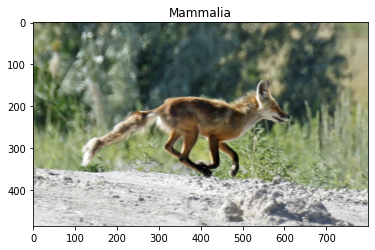

In [9]:
#Take a random image from the testing data to see the guided backprop effect

import random

path = '/content/drive/MyDrive/DL_DATA_iNat/val/'

Class_num = random.randint(0,9)
files = os.listdir(path+classes[Class_num])

file_num = random.randint(0,len(files)-1)
print("Class num = " + str(Class_num) + " "+classes[Class_num])
plt.imshow(Image.open(path+classes[Class_num]+'/'+files[file_num]))
plt.title(classes[Class_num])

In [10]:
#Getting the image in tensor form-----------------------------------------------
fin_layer = model.get_layer("conv2d_4").output.shape[1:]
test_img = Image.open(path+classes[Class_num]+'/'+files[file_num])
test_img = test_img.resize((227,227))
t_img_arr = np.asarray(test_img)*1./255

#Computing and saving the guided backprop results ------------------------------
guid_backprops = []
numOfNeurons = 10
for i in range(numOfNeurons):
  neuron = [np.random.randint(0,d-1) for d in fin_layer]
  mask = np.zeros(fin_layer)
  mask[neuron[0],neuron[1],neuron[2]] = 1
  with tf.GradientTape() as tape:
    inps = tf.cast([t_img_arr], tf.float32)
    tape.watch(inps)
    ops = gd_bp_model(inps) * mask
  guid_backprops.append((neuron,tape.gradient(ops,inps)[0]))

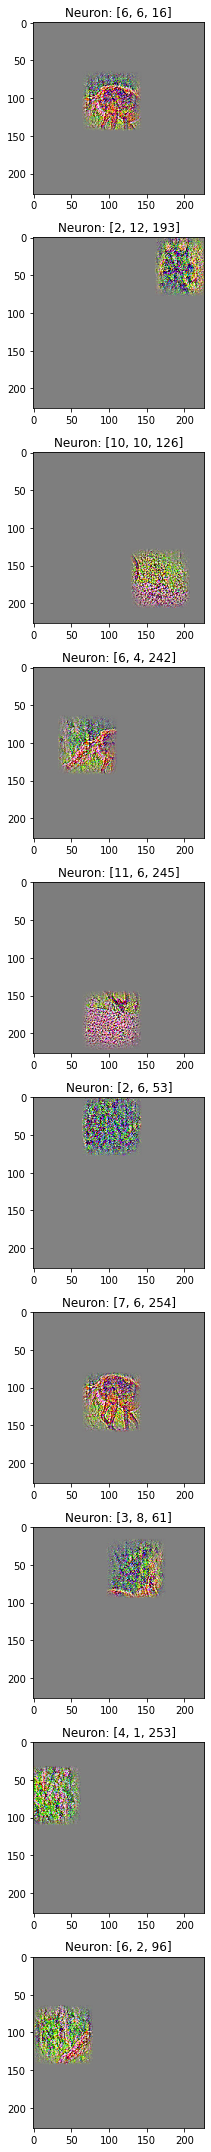

In [20]:
#plotting the images obtained in previous step ---------------------------------

fig,ax = plt.subplots(numOfNeurons,1,figsize=(5,30))

for i,(neuron,image) in enumerate(guid_backprops):
    ax[i].imshow(deprocess_image(np.array(image)))
    ax[i].set_title("Neuron: {}".format(neuron))
    
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/DL_DATA_iNat/PA-Q5-2.png',bbox_inches='tight')